<a href="https://colab.research.google.com/github/MichalBalcerak/ML24-25/blob/main/Homework04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt
from sklearn.utils import resample

I generate data based on linear relationship:
$$y=\beta_0+\beta_1x_1+\dots+\beta_nx_n+\epsilon
$$
where
$$\epsilon\sim\mathcal{N}(0,\sigma^2)$$
All these parameters are known (estabilished):\
I select $\sigma^2=1$, $n=50$ and only 5 $\beta_i\neq0$. My data size is 100 samples.

In [ ]:
n_samples = 100
n_features = 50
n_non_zero_betas = 5
noise_var = 1.0

np.random.seed(42)

beta = np.zeros(n_features)
nonzero_indices = np.random.choice(n_features, n_non_zero_betas, replace=False)
beta[nonzero_indices] = np.random.randn(n_non_zero_betas)

true_X = np.random.randn(n_samples, n_features)
true_y = true_X @ beta + np.random.normal(0, 1.0, size=n_samples)


I implement LASSO and RIDGE regression for 50 different $\alpha$ values. For each $\alpha$ there is 100 trials, just to calculate **MSE**, **variance** and **bias** across the trials. Firstly, I define function which will be used to train and evaluate a model. I decided to generate a new sample with noise for each iteration.

In [ ]:
alphas = np.logspace(-4, 3, 50)
n_trials = 100
def evaluate_model(ModelClass):
    bias2_list = []
    var_list = []
    mse_list = []

    for alpha in alphas:
        predictions = []
        for i in range(n_trials):
            X_sample = np.random.randn(n_samples, n_features)
            noise_sample = np.random.normal(0, 1.0, size=n_samples)
            y_sample = X_sample @ beta + noise_sample

            model = ModelClass(alpha=alpha)
            model.fit(X_sample, y_sample)
            y_pred = model.predict(true_X)
            predictions.append(y_pred)

        predictions = np.array(predictions)
        mean_pred = np.mean(predictions, axis=0)

        bias2 = np.mean((mean_pred - true_y) ** 2)
        var = np.mean(np.var(predictions, axis=0))
        total_mse = bias2 + var

        bias2_list.append(bias2)
        var_list.append(var)
        mse_list.append(total_mse)

    return bias2_list, var_list, mse_list


In [ ]:
ridge_bias, ridge_var, ridge_mse = evaluate_model(Ridge)
lasso_bias, lasso_var, lasso_mse = evaluate_model(Lasso)

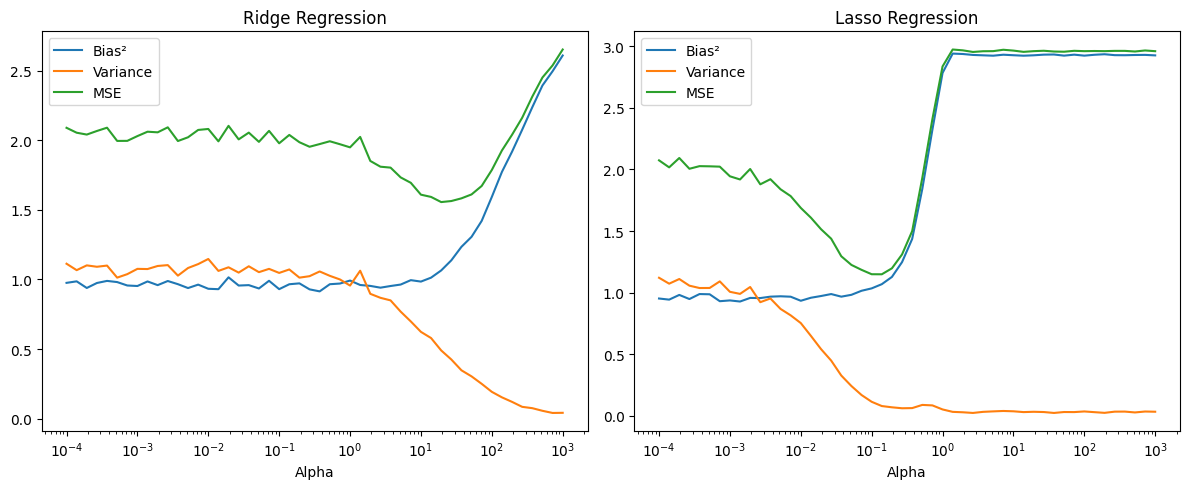

In [ ]:
plt.figure(figsize=(12, 5))

# Ridge
plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_bias, label="Bias²")
plt.plot(alphas, ridge_var, label="Variance")
plt.plot(alphas, ridge_mse, label="MSE")
plt.xscale("log")
plt.title("Ridge Regression")
plt.xlabel("Alpha")
plt.legend()

# Lasso
plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_bias, label="Bias²")
plt.plot(alphas, lasso_var, label="Variance")
plt.plot(alphas, lasso_mse, label="MSE")
plt.xscale("log")
plt.title("Lasso Regression")
plt.xlabel("Alpha")
plt.legend()

plt.tight_layout()
plt.show()
